# Adversarial Chess
6.4212 Final Project

Kameron Dawson

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    DiagramBuilder, StartMeshcat, Simulator, Rgba, RigidTransform
)
from pydrake.geometry import Sphere
from manipulation.station import LoadScenario, MakeHardwareStation, AddPointClouds, MakeMultibodyPlant
from manipulation.utils import RenderDiagram
from setup_simulation import get_scenario
from utils import visualize_box, visualize_text, visualize_iiwa_reachability, find_home_configuration
from motion.motion import TrajectoryController
from grasp.grasp import GraspController
from control.controller import Controller

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Setup meshcat for visualization
meshcat = StartMeshcat()
print('Click the link above to open Meshcat in your browser!')

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [3]:
# Clear meshcat
meshcat.Delete()

In [4]:
# Get scenario
scenario_string = get_scenario()

# Load the scenario and build the simulation station
scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)

# Build a Drake Diagram containing the station
builder = DiagramBuilder()
builder.AddSystem(station)

# Setup getting point clouds from the cameras
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder # can render w/ meshcat but much slower
)
builder.ExportOutput(to_point_cloud['camera0'].get_output_port(), 'camera0_point_cloud')
builder.ExportOutput(to_point_cloud['camera1'].get_output_port(), 'camera1_point_cloud')
builder.ExportOutput(to_point_cloud['camera2'].get_output_port(), 'camera2_point_cloud')

# Make a plant including only the iiwa and gripper for the controllers
plant_iiwa1 = MakeMultibodyPlant(
    scenario=scenario, model_instance_names=['iiwa1', 'wsg1']
)
plant_iiwa2 = MakeMultibodyPlant(
    scenario=scenario, model_instance_names=['iiwa2', 'wsg2']
)

# Get their contexts
plant_context_iiwa1 = plant_iiwa1.CreateDefaultContext()
plant_context_iiwa2 = plant_iiwa2.CreateDefaultContext()

# Add controllers
iiwa1_traj_controller = builder.AddSystem(TrajectoryController(plant_iiwa1))
iiwa2_traj_controller = builder.AddSystem(TrajectoryController(plant_iiwa2))
iiwa1_grasp_controller = builder.AddSystem(GraspController(plant_iiwa1))
iiwa2_grasp_controller = builder.AddSystem(GraspController(plant_iiwa2))

# Connect ports
builder.Connect(station.GetOutputPort('iiwa1.position_measured'), iiwa1_traj_controller.GetInputPort('q_actual'))
builder.Connect(station.GetOutputPort('iiwa2.position_measured'), iiwa2_traj_controller.GetInputPort('q_actual'))
builder.Connect(iiwa1_traj_controller.GetOutputPort('q_desired'), station.GetInputPort('iiwa1.position'))
builder.Connect(iiwa2_traj_controller.GetOutputPort('q_desired'), station.GetInputPort('iiwa2.position'))
builder.Connect(station.GetOutputPort('wsg1.state_measured'), iiwa1_grasp_controller.GetInputPort('q_actual'))
builder.Connect(station.GetOutputPort('wsg2.state_measured'), iiwa2_grasp_controller.GetInputPort('q_actual'))
builder.Connect(iiwa1_grasp_controller.GetOutputPort('q_desired'), station.GetInputPort('wsg1.position'))
builder.Connect(iiwa2_grasp_controller.GetOutputPort('q_desired'), station.GetInputPort('wsg2.position'))

# Build diagram
diagram = builder.Build()

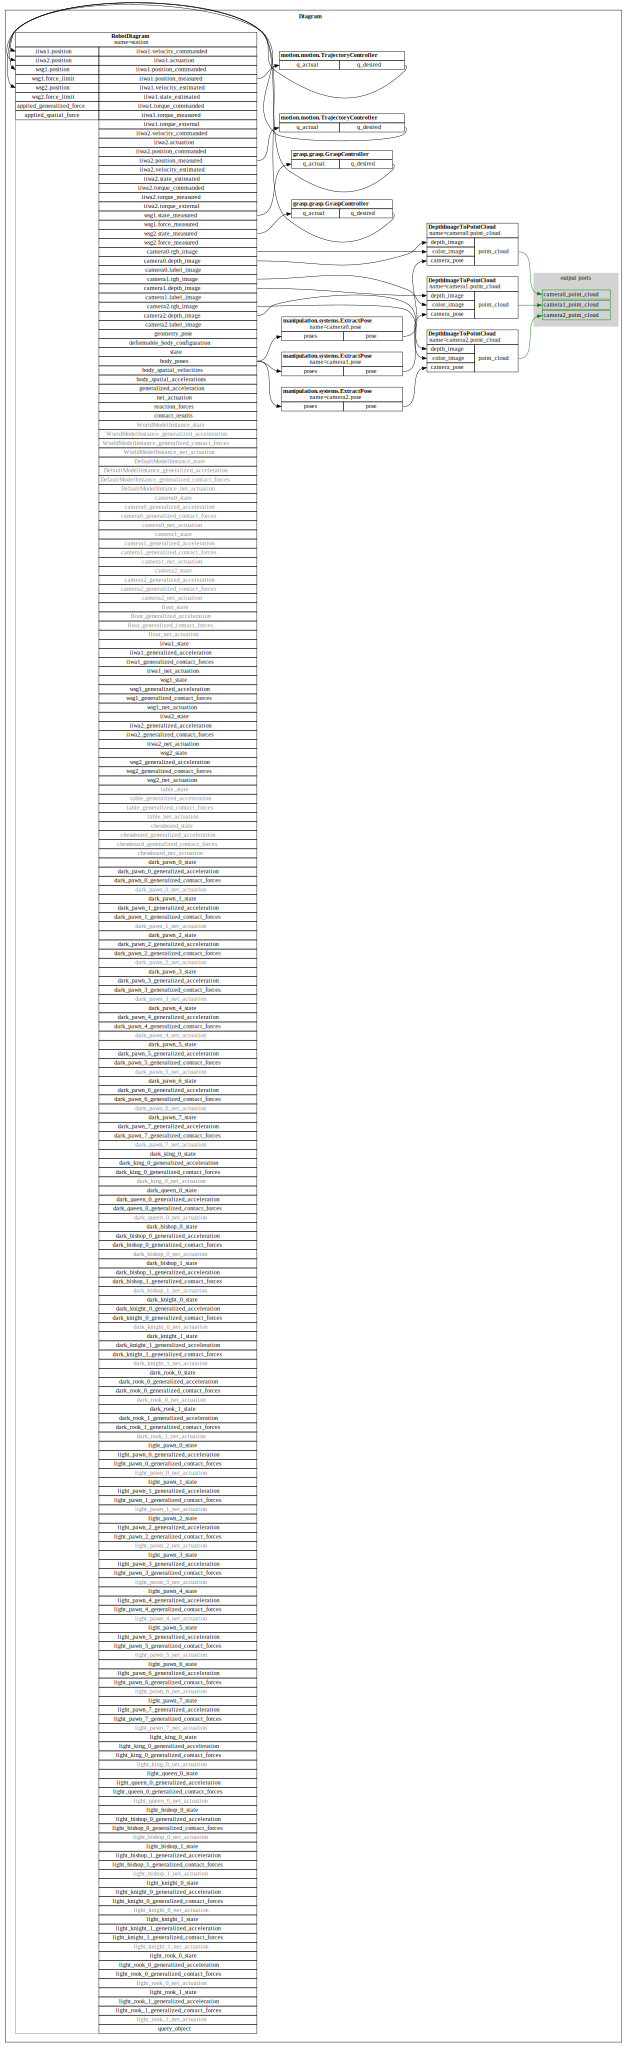

In [5]:
RenderDiagram(diagram, max_depth=1)

In [6]:
# Get relevant vars from the diagram, station
context = diagram.CreateDefaultContext()
plant = station.plant()
plant_context = diagram.GetSubsystemContext(plant, context)

In [7]:
# Create and run a simulator
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.1)

In [8]:
# visualize_iiwa_reachability(meshcat, plant_iiwa2, N=1000)

In [9]:
# home, perf = find_home_configuration(plant_iiwa1, plant_context_iiwa1, n_candidates=10000, pos_tol=0.05, rot_tol=0.05)
# print('Home configuration: ', home)
# print('Relative improvement: ', perf)

In [10]:
# Setup the overall controller
controller = Controller(diagram, context, simulator, iiwa1_traj_controller, iiwa2_traj_controller, iiwa1_grasp_controller, iiwa2_grasp_controller)

## Perception

### Sanity Check Cameras

In [ ]:
# Run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

plt.show()

In [ ]:
# Run the following cell to visualize the depth outputs of each of the cameras
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()

### Sanity Check Perception

In [ ]:
# Get poses of every chess piece
piece_poses = controller.get_piece_poses()

In [ ]:
# Visualize poses as sanity check
colors = {
    'p': Rgba(1, 0, 0), # red
    'k': Rgba(0, 1, 0), # green
    'q': Rgba(0, 0, 1), # blue
    'b': Rgba(1, 1, 0), # yellow
    'n': Rgba(0, 1, 1), # cyan
    'r': Rgba(1, 0, 1) # magenta
}

for piece, poses in piece_poses.items():
    for i, X in enumerate(poses):
        path = f'/piece/{piece}{i}'
        meshcat.SetTransform(path, X)
        meshcat.SetObject(
            path, Sphere(0.01), rgba=colors[piece.lower()]
        )

In [ ]:
from perception.perception import perception

perception_result = perception(controller.diagram, controller.context, controller.oriented_model_piece_point_clouds, debugging=True)
# Visualize piece clouds
piece_pcs = perception_result['piece_pcs']
for color in piece_pcs:
    for piece, pc in piece_pcs[color].items():
        rgb = Rgba(1, 1, 1) if color == 'light' else Rgba(0, 0, 0)
        meshcat.SetObject(
            f'piece_pc_{color}_{piece}', pc, point_size=0.0025, rgba=rgb
        )

# Visualize piece bounding boxes
for color in piece_pcs:
    for piece, pc in piece_pcs[color].items():
        pts = pc.xyzs()
        x, y, z = pts[0], pts[1], pts[2]
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        min_z, max_z = np.min(z), np.max(z)
        lower, upper = np.array([min_x, min_y, min_z]), np.array([max_x, max_y, max_z])
        visualize_box(meshcat, lower, upper, f'piece_bb_{color}_{piece}_{i}')

## Motion Planning

In [11]:
controller.control_loop(None)

Home
Gripper opened
Pre-pick to pick
Gripper closed
Pre-pick to home
Pre-place to place
Gripper opened
Pre-place to home


In [ ]:
X = RigidTransform()
X.set_translation([-0.16449999999999998, 0.07050000000000001, 0.527262])
path = '/place'
meshcat.SetTransform(path, X)
meshcat.SetObject(
    path, Sphere(0.01), rgba=Rgba(1, 0, 0)
)